In [ ]:
import os
import pandas as pd
import numpy as np
import cv2
import csv
import tensorflow as tf
import keras
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import BatchNormalization
from keras import backend as K
from keras.models import model_from_json,load_model

from keras.metrics import Precision
from keras.metrics import Recall

from sklearn.preprocessing import MinMaxScaler
from google.colab import drive


In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
IMG_HEIGHT=256
IMG_WIDTH=256
IMG_CHANNELS=3

In [ ]:
folder_path=os.path.join(os.getcwd(),'drive','MyDrive','Colab Notebooks','datasets','UCMerced_LandUse','Images')
X_train=list()
X_test=list()
y_train=list()
y_test=list()
target=dict()

count=0
for i in os.listdir(folder_path):
    target[i]=count
    count=count+1


In [ ]:
val=1
train_data=list()
target_data=list()

for directory in os.listdir(folder_path):
    temp_folder=os.path.join(folder_path,directory)
    list_files=os.listdir(temp_folder)
    for i in range(0,len(list_files)):
        temp_path=os.path.join(temp_folder,list_files[i])
        train_data.append(temp_path)
        target_data.append([target[directory]])

In [ ]:
from tqdm import tqdm_notebook, tnrange

X=list()
y=list()

for n,val in tqdm_notebook(enumerate(train_data), total=len(train_data)):
  img = cv2.imread(train_data[n])
  img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))
  X.append(img)
  
X=np.array(X)
y=np.array(target_data)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(X,y, random_state=42, test_size = 0.2 )

#X_train,X_test,y_train,y_test=train_test_split(X_train,y_train, random_state=42, test_size = 0.1 )

#X_train=np.array(X_train)
#X_train = np.expand_dims(X_train, axis=3)

#X_test=np.array(X_test)
#X_test=np.expand_dims(X_test,axis=3)

print(X_train.shape)
print(y_train.shape)
#print(X_valid.shape)
#print(len(y_train))
#print(len(y_test))

(1680, 256, 256, 3)
(1680, 1)


Data Normalization

In [ ]:
from keras.utils import normalize, to_categorical

X_train = normalize(X_train, axis=1)
X_valid = normalize(X_valid, axis=1)

y_train = to_categorical(y_train)
y_valid = to_categorical(y_valid)


Data Augmentation

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rotation_range=45,
    width_shift_range=0.2,
    zoom_range = 0.2,
    horizontal_flip = True)
train_datagen.fit(X_train)

train_generator = train_datagen.flow(
    X_train,
    y_train,
    batch_size = 32)

In [ ]:
activation = 'sigmoid'
model = Sequential()
model.add(Conv2D(32, 3, activation = activation, padding = 'same', input_shape = (IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS)))
model.add(BatchNormalization())

model.add(Conv2D(32, 3, activation = activation, padding = 'same', kernel_initializer = 'he_uniform'))
model.add(BatchNormalization())
model.add(MaxPooling2D())

model.add(Conv2D(64, 3, activation = activation, padding = 'same', kernel_initializer = 'he_uniform'))
model.add(BatchNormalization())

model.add(Conv2D(64, 3, activation = activation, padding = 'same', kernel_initializer = 'he_uniform'))
model.add(BatchNormalization()) 
model.add(MaxPooling2D())

model.add(Conv2D(128, 3, activation = activation, padding = 'same', kernel_initializer = 'he_uniform'))
model.add(BatchNormalization())

model.add(Conv2D(128, 3, activation = activation, padding = 'same', kernel_initializer = 'he_uniform'))
model.add(BatchNormalization()) 
model.add(MaxPooling2D())

model.add(Conv2D(256, 3, activation = activation, padding = 'same', kernel_initializer = 'he_uniform'))
model.add(BatchNormalization())

model.add(Conv2D(256, 3, activation = activation, padding = 'same', kernel_initializer = 'he_uniform'))
model.add(BatchNormalization()) 
model.add(MaxPooling2D())

model.add(Conv2D(512, 3, activation = activation, padding = 'same', kernel_initializer = 'he_uniform'))
model.add(BatchNormalization())

model.add(Conv2D(512, 3, activation = activation, padding = 'same', kernel_initializer = 'he_uniform'))
model.add(BatchNormalization()) 
model.add(MaxPooling2D())

model.add(Flatten())
model.add(Dense(128, activation = activation, kernel_initializer = 'he_uniform'))
model.add(Dense(64, activation = activation, kernel_initializer = 'he_uniform'))
model.add(Dense(21, activation = 'softmax'))

model.compile(optimizer = 'adam',loss = 'categorical_crossentropy', metrics = ['accuracy',Precision(),Recall()])
print(model.summary()) 

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 256, 256, 32)      896       
_________________________________________________________________
batch_normalization_10 (Batc (None, 256, 256, 32)      128       
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 256, 256, 32)      9248      
_________________________________________________________________
batch_normalization_11 (Batc (None, 256, 256, 32)      128       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 128, 128, 64)      18496     
_________________________________________________________________
batch_normalization_12 (Batc (None, 128, 128, 64)     

In [ ]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

#earlystopper = EarlyStopping(patience=1000, verbose=1)
checkpointer = ModelCheckpoint('model-landuse-2-data-augmentation.h5', verbose=1, save_freq="epoch")
history = model.fit(train_generator,epochs = 500,validation_data = (X_valid, y_valid),callbacks=[checkpointer])
model.save(os.path.join(os.getcwd(),'model-landuse-2-data-augmentation.h5'))

Epoch 1/500
53/53 [==============================] - 25s 447ms/step - loss: 3.0306 - accuracy: 0.0949 - precision_1: 0.0000e+00 - recall_1: 0.0000e+00 - val_loss: 3.0698 - val_accuracy: 0.0381 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00

Epoch 00001: saving model to model-landuse-2-data-augmentation.h5
Epoch 2/500
53/53 [==============================] - 23s 431ms/step - loss: 2.6859 - accuracy: 0.1925 - precision_1: 0.0000e+00 - recall_1: 0.0000e+00 - val_loss: 3.2251 - val_accuracy: 0.0524 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00

Epoch 00002: saving model to model-landuse-2-data-augmentation.h5
Epoch 3/500
53/53 [==============================] - 23s 431ms/step - loss: 2.5160 - accuracy: 0.2380 - precision_1: 0.0000e+00 - recall_1: 0.0000e+00 - val_loss: 3.5109 - val_accuracy: 0.0524 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00

Epoch 00003: saving model to model-landuse-2-data-augmentation.h5
Epoch 4/500
53/53 [==============================

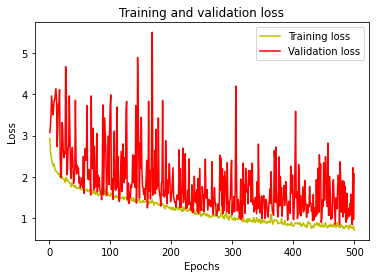

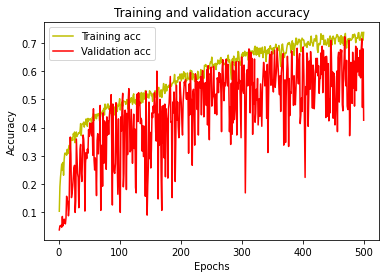

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
reconstructed_model = keras.models.load_model("model-landuse-2-data-augmentation.h5")
y_train_class=list()
y_train_pred_class=list()

y_train_pred=reconstructed_model.predict(X_train)

for i in range(0,len(y_train)):
  y_train_class.append(np.argmax(y_train[i]))
  y_train_pred_class.append(np.argmax(y_train_pred[i]))

In [ ]:
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score
from sklearn.metrics import classification_report,confusion_matrix

print('Accuracy:', accuracy_score(y_train_class, y_train_pred_class))
print('F1 score:', f1_score(y_train_class, y_train_pred_class,average=None))
print('Recall:', recall_score(y_train_class, y_train_pred_class,average=None))
print('Precision:', precision_score(y_train_class, y_train_pred_class,average=None))
print('Clasification Report\n', classification_report(y_train_class, y_train_pred_class))
print('Confussion Matrix:\n',confusion_matrix(y_train_class, y_train_pred_class))

Accuracy: 0.47023809523809523
F1 score: [0.41833811 0.3875969  0.         0.30701754 0.36904762 0.4742268
 0.68493151 0.16806723 0.28828829 0.27631579 0.5229682  0.32116788
 0.57399103 0.4        0.2247191  0.9261745  0.375      0.79289941
 0.10989011 0.64634146 0.82162162]
Recall: [0.92405063 0.30120482 0.         0.4375     0.40789474 0.31081081
 0.91463415 0.12048193 0.19512195 0.25       0.925      0.26829268
 0.75294118 0.2739726  0.12987013 0.8961039  0.25301205 0.8375
 0.05813953 0.64634146 0.97435897]
Precision: [0.27037037 0.54347826 0.         0.23648649 0.33695652 1.
 0.54744526 0.27777778 0.55172414 0.30882353 0.36453202 0.4
 0.46376812 0.74074074 0.83333333 0.95833333 0.72413793 0.75280899
 1.         0.64634146 0.71028037]

 clasification report:
               precision    recall  f1-score   support

           0       0.27      0.92      0.42        79
           1       0.54      0.30      0.39        83
           2       0.00      0.00      0.00        74
           

In [ ]:
_, accuracy, precision, recall = model.evaluate(X_valid, y_valid)
print(accuracy,precision,recall)

14/14 [==============================] - 0s 30ms/step - loss: 2.0767 - accuracy: 0.4262 - precision_1: 0.4952 - recall_1: 0.3690
0.42619046568870544 0.49520766735076904 0.369047611951828


In [ ]:
loaded_model=keras.models.load_model('model-landuse-2-data-augmentation.h5')